# Box measurements demo

## Idea
  * Find a ground plane, find a plane for the top of the box
  * Find a minimum rectangle for the top side (and four points)
  * Find the bottom four corners of the box (located on the ground plane).

## What is needed for a bare minimum working demo:
 * Crop only for the ROI *DONE*
 * Detect the ground plane, either using calibration (detect the background without the box) or if
the box is small enough, do the fit using the box. *DONE*

 * Find a rotation matrix to align the ground plane with the coordinate system. *DONE*

 * Find points not on the plane and perform clustering, in good conditions, the biggest cluster should be the box. *DONE*

 * Order the points by the distance to the ground plane *DONE*

 * Take the 0.90% of the point furthest away from the plane *DONE*

 * Make a new plane parallel to the ground plane *NOT NEEDED*

 * Do a projection of the points that are in the +- x% of the new plane on the new plane

 * Find a bounding box around the projected points**

 * Get the 4 coordinates of the bounding box

 * Get the 4 coordinates on the ground plane by projection

 * By here the demo should be able to measure the box dimensions


## What else is needed for the full demo:
 * Figure out an reverse transformation to the RGB image to draw the box on the image
 * Gather more than one point cloud and (average/combine) them.
 * Create a calibration setup

## Helper funtions:
 * A function that creates a point cloud for a plane in a given volume would be handy for visualisation.

In [4]:
# Imports and constants

import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import copy
import cv2
import random

id = 1
PATH_DIR = "./media/example_pcls"
PATH = f"{PATH_DIR}/example_{id}.ply"

In [5]:
# Read the pointcloud
raw_pcl = o3d.io.read_point_cloud(PATH)

### Crop the ROI
----

In [6]:
# Show the pointcloud
o3d.visualization.draw_geometries([raw_pcl])

2025-03-24 13:49:52.785 python3.10[34271:6392607] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-24 13:49:52.785 python3.10[34271:6392607] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [7]:
# Crop only for the ROI

raw_pcl_np = np.asarray(raw_pcl.points)

# Calculate point distances
pcl_dist = np.sqrt(np.sum(np.square(raw_pcl_np), axis=1))

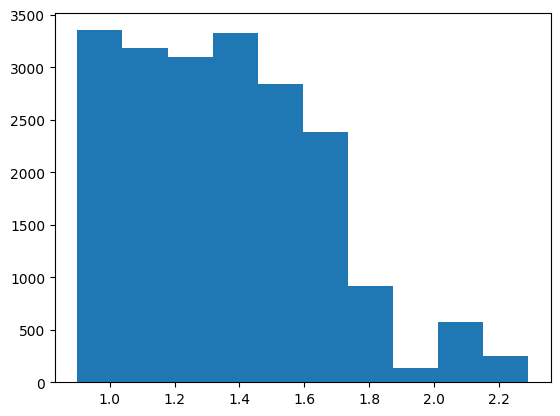

In [8]:
# Plot a histogram of distances
plt.hist(pcl_dist)
plt.show()

In [9]:
# Only take points less than 1 meter away
indices = np.nonzero(pcl_dist < 1.5)[0]
roi_pcl = raw_pcl.select_by_index(indices)

o3d.visualization.draw_geometries([roi_pcl])

### Detect the ground plane
------

In [10]:
# Get the ground plane
plane_eq, plane_inliers = roi_pcl.segment_plane(0.02, 3, 3000)


# Draw the datapoints in the plane
plane_raw = roi_pcl.select_by_index(plane_inliers)
o3d.visualization.draw_geometries([plane_raw])

# Draw the outliers
plane_outliers = roi_pcl.select_by_index(plane_inliers, invert=True)
o3d.visualization.draw_geometries([plane_outliers])
# TODO, draw a plane, to compare visually how this works

### Find the box

In [13]:
# Cluster the outliers, the biggest in good conditions should be the box
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(plane_outliers.cluster_dbscan(eps=0.02, min_points=10))


max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
plane_outliers.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([plane_outliers])

[Open3D DEBUG] Precompute neighbors.
[Open3D DEBUG] Done Precompute neighbors.
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 7
point cloud has 7 clusters


In [15]:
# Visualize the biggest cluster (hopefully the box)
labels_short = labels[labels != -1]
y = np.bincount(labels_short).argmax()
box_indices = np.where(labels == y)[0]
box = plane_outliers.select_by_index(box_indices)
o3d.visualization.draw_geometries([box])

### Helper functions

In [14]:
# Useful for debugging (see what RANSAC is finding visually)


def create_pointcloud_plane(plane_params, x_range, y_range, step):
    """
    Create a pointcloud from the plane parameters and ranges
         Parameters:
         --------------
         plane_params -> list() 4x1
         x, y ,z range -> list 2x1 ([min, max])

         Returns:
         point_cloud

    """
    pcl = o3d.geometry.PointCloud()
    a, b, c, d = plane_params
    x_start, x_stop = x_range
    y_start, y_stop = y_range
    num_points_x = int((x_stop - x_start) / step) + 1
    num_points_y = int((y_stop - y_start) / step) + 1
    x_points = np.linspace(x_start, x_stop, num_points_x)
    y_points = np.linspace(y_start, y_stop, num_points_y)
    num_points = len(x_points) * len(y_points)
    pcl_np = np.ones((num_points, 3))
    i = 0
    for x in x_points:
        for y in y_points:
            z = (-d - (a * x) - (b * y)) / c
            pcl_np[i] = np.array([x, y, z])
            i += 1

    pcl.points = o3d.utility.Vector3dVector(pcl_np)

    return pcl


def fit_plane_vec_constraint(norm_vec, pts, thresh=0.05, n_iterations=1000):
    best_eq = []
    best_inliers = []

    n_points = pts.shape[0]
    for iter in range(n_iterations):
        id_sample = random.sample(range(0, n_points), 1)
        point = pts[id_sample]
        d = -np.sum(np.multiply(norm_vec, point))
        plane_eq = [*norm_vec, d]
        pt_id_inliers = get_plane_inliers(plane_eq, pts, thresh)
        if len(pt_id_inliers) > len(best_inliers):
            best_eq = plane_eq
            best_inliers = pt_id_inliers

    return best_eq, best_inliers


def fit_plane_z0(pts, thresh=0.05, n_iterations=1000):
    best_eq = []
    best_inliers = []
    # Fit the plane where a constraint is for the z component of
    # the normal vector is to be 0

    n_points = pts.shape[0]
    for iter in range(n_iterations):
        id_samples = random.sample(range(0, n_points), 2)
        points = pts[id_samples]

        # Get the line between two points
        vec_line = points[1, :2] - points[0, :2]

        # Normal vector is perpendicular
        vecC = [vec_line[1], -vec_line[0], 0]

        # Normalize
        norm_vec = vecC / np.linalg.norm(vecC)

        point = points[0, :]
        d = -np.sum(np.multiply(norm_vec, point))
        plane_eq = [*norm_vec, d]
        pt_id_inliers = get_plane_inliers(plane_eq, pts, thresh)
        if len(pt_id_inliers) > len(best_inliers):
            best_eq = plane_eq
            best_inliers = pt_id_inliers

    return best_eq, best_inliers


def get_plane_inliers(plane_eq, pts, thresh=0.05):
    pt_id_inliers = []
    dist_pt = get_pts_distances_plane(plane_eq, pts)

    # Select indexes where distance is bigger than the threshold
    pt_id_inliers = np.where(np.abs(dist_pt) <= thresh)[0]
    return pt_id_inliers


def get_intersection_three_planes(planes_eq):
    A, B, C = planes_eq
    line_dir, line_point = get_intersection_two_planes([A, B])

    plane_normal = np.array(C[0:2])

    ndotu = plane_normal.dot(line_dir)
    plane_point = [0, 0, 0]  # TODO
    w = line_point - plane_point
    si = -np.array(C[0:2]).dot(w) / ndotu

    point = w + si * line_dir + plane_point
    return point


def norm2(X):
    return np.sqrt(np.sum(X**2))


def normalized(X):
    return X / norm2(X)


def get_intersection_two_planes(planes_eq):
    A, B = planes_eq
    U = normalized(np.cross(A[:-1], B[:-1]))
    M = np.array((A[:-1], B[:-1], U))
    X = np.array((-A[-1], -B[-1], 0.0))
    return U, np.linalg.solve(M, X)  # [a,b,c], [x0, y0, z0]


def get_pts_distances_plane(plane_eq, pts):
    dist_pt = (
        plane_eq[0] * pts[:, 0]
        + plane_eq[1] * pts[:, 1]
        + plane_eq[2] * pts[:, 2]
        + plane_eq[3]
    ) / np.sqrt(plane_eq[0] ** 2 + plane_eq[1] ** 2 + plane_eq[2] ** 2)
    return dist_pt

In [11]:
# pointcloud = create_pointcloud_plane([0, 0, 1, -1], [0,2], [-2,2], 0.02)

# coord = o3d.geometry.TriangleMesh.create_coordinate_frame()
# pointcloud.paint_uniform_color([0,255,0])
# o3d.visualization.draw_geometries([pointcloud, coord])

## Fit the box with pyRansac cube fit and visualise the result

In [17]:
import pyransac3d as pyrsc

box_points = np.asarray(box.points)
cube = pyrsc.Cuboid()
best_eq, best_inliers = cube.fit(box_points, thresh=0.015, maxIteration=3000)


box_insiders = box.select_by_index(best_inliers)
o3d.visualization.draw_geometries([box_insiders])

In [18]:
percent_inliers = 100 * (len(best_inliers) / len(box.points))
print(f"How many percent inliers: {percent_inliers}%")

How many percent inliers: 95.8171206225681%


In [19]:
box_points

array([[ 0.0391963 , -0.11599102, -0.94971429],
       [ 0.04938117, -0.11298155, -0.95066669],
       [ 0.05686342, -0.10971594, -0.954     ],
       ...,
       [ 0.01650611, -0.05068626, -0.94499999],
       [ 0.07086273, -0.05569545, -0.9409    ],
       [ 0.07983237, -0.05480072, -0.94825   ]], shape=(1028, 3))

In [20]:
per_inliers_per_plane = []
for eq in best_eq:
    box_inliers = get_plane_inliers(eq, box_points, 0.015)
    per_inliers_per_plane.append(len(box_inliers) / len(box_points) * 100)

In [21]:
per_inliers_per_plane

[83.56031128404669, 16.147859922178988, 10.894941634241246]

In [22]:
# Visualize the box planes

planes = []
for i, eq in enumerate(best_eq):
    if per_inliers_per_plane[i] > 5:
        planes.append(create_pointcloud_plane(eq, [-1, 1], [-1, 1], 0.01))

o3d.visualization.draw_geometries(planes + [box])

# Rotate and translate the ground plane
Rotate the ground plane along the x or y axis so the normal vector
of the ground plane is only positive in the z direction.
The translate the ground plane to have zero distance with the origin.

In [23]:
# Calculate the rotation matrix


def rotate_vector(vec_in, vec_target):
    # Create a rotation matrix that rotates vec_in to vec_target
    # https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d
    v = np.cross(vec_in, vec_target)
    s = np.linalg.norm(v)
    c = np.matmul(vec_in, vec_target)
    v_mat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    R = np.identity(3) + v_mat + (np.matmul(v_mat, v_mat) * (1 / (1 + c)))
    return R

In [24]:
norm_vector = plane_eq[0:3]
wanted_norm_vector = np.array([0, 0, 1])
rot_matrix = rotate_vector(norm_vector, wanted_norm_vector)

# Create visible coordinates
coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)
rotated_plane = copy.deepcopy(plane_raw)
rotated_plane = rotated_plane.rotate(rot_matrix, center=(0, 0, 0))
o3d.visualization.draw_geometries([coord, rotated_plane])


avg_z = np.average(np.asarray(rotated_plane.points)[:, 2])
translated_plane = rotated_plane.translate([0, 0, -avg_z])
o3d.visualization.draw_geometries([coord, rotated_plane])

In [25]:
# Check that the normal vector really is pointing up
np.matmul(rot_matrix, norm_vector)

array([1.38777878e-17, 5.55111512e-17, 1.00000000e+00])

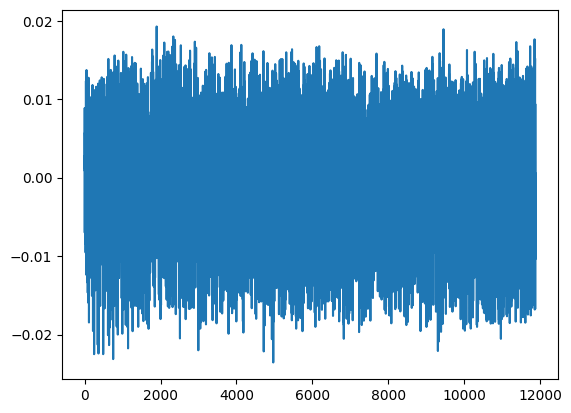

In [26]:
# Draw all z values
points = np.asarray(rotated_plane.points)
plt.plot(points[:, 2])
plt.show()

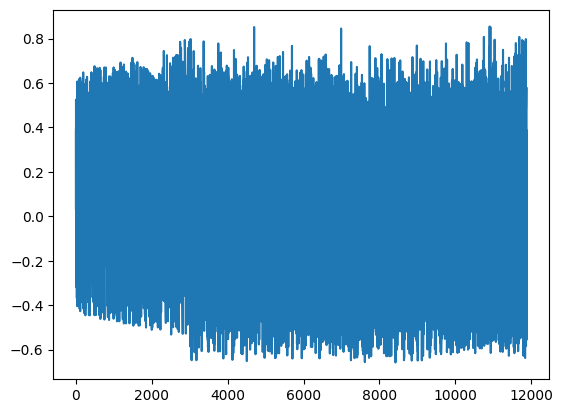

In [27]:
plt.plot(points[:, 0])

### Order the points and take the ones furthest away from the plane

In [28]:
# Rotate and translate also the box

rotated_box = copy.deepcopy(box)
rotated_box = rotated_box.rotate(rot_matrix, center=(0, 0, 0))
translated_box = rotated_box.translate([0, 0, -avg_z])
o3d.visualization.draw_geometries([coord, translated_box, translated_plane])

In [29]:
# Fit the z plane
translated_box_points = np.asarray(translated_box.points)
top_plane_eq, top_plane_inliers = fit_plane_vec_constraint(
    [0, 0, 1], translated_box_points, 0.03, 30
)
top_plane = translated_box.select_by_index(top_plane_inliers)

In [30]:
# Fit another plane
side_plane_eq, side_plane_inliers = fit_plane_z0(translated_box_points, 0.015, 100)
side_plane = translated_box.select_by_index(side_plane_inliers)

In [31]:
# points_np = np.asarray(translated_box.points)
# zs = points_np[:, 2]
# sorted_zs = np.sort(zs)
# plt.plot(sorted_zs)
# percentile90 = np.percentile(sorted_zs, 90)
height = -top_plane_eq[3]

o3d.visualization.draw_geometries([translated_plane, top_plane, side_plane])

In [32]:
# Rotate to get the box aligned to coordinate system
R = rotate_vector(side_plane_eq[0:3], [0, 1, 0])
aligned_box = copy.deepcopy(rotated_box)
aligned_box = aligned_box.rotate(R, center=(0, 0, 0))
aligned_box = aligned_box.translate([0, side_plane_eq[3], 0])
coord = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.1)

o3d.visualization.draw_geometries([aligned_box, coord])

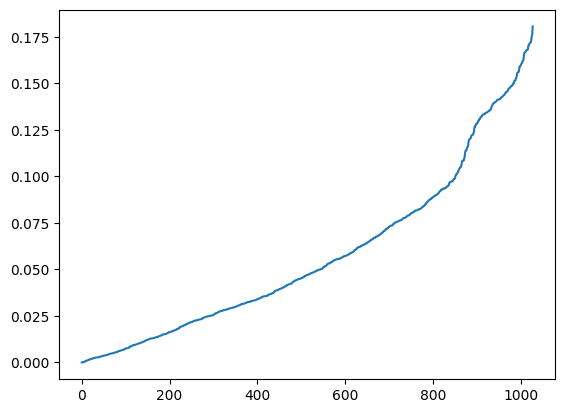

In [33]:
aligned_box_points = np.asarray(aligned_box.points)
ys = abs(aligned_box_points[:, 1])
ys.sort()
width = np.percentile(ys, 98)
plt.plot(ys)

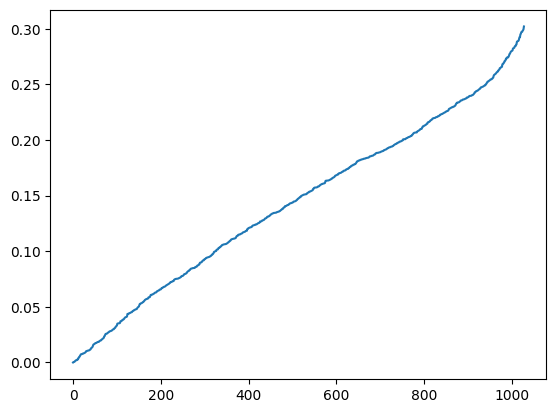

In [34]:
xs = abs(aligned_box_points[:, 0])
xs.sort()
xs = xs - min(xs)
length = np.percentile(xs, 98)
plt.plot(xs)

In [35]:
print(width, length)

0.16365689264302516 0.28425353332378067


### Bounding box on the 2D points
rect = cv2.minAreaRect(points)
points = cv2.boxPoints(rect)
bottom_points = points, just reducted z by the distance between the planes


---

In [36]:
upper_plane_points = np.asarray(top_plane.points)
coordinates = np.c_[upper_plane_points[:, 0], upper_plane_points[:, 1]].astype(
    "float32"
)
rect = cv2.minAreaRect(coordinates)
bounding_box = cv2.boxPoints(rect)

### Visualise the box borders

In [37]:
points_floor = np.c_[bounding_box, np.zeros(4)]
points_top = np.c_[bounding_box, height * np.ones(4)]
box_points = np.concatenate((points_top, points_floor))


rotated_whole_pcl = copy.deepcopy(raw_pcl)
rotated_whole_pcl = rotated_whole_pcl.rotate(rot_matrix, center=(0, 0, 0))
translated_whole_pcl = rotated_whole_pcl.translate([0, 0, -avg_z])


lines = [
    [0, 4],
    [1, 5],
    [2, 6],
    [3, 7],
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
    [4, 5],
    [5, 6],
    [6, 7],
    [7, 4],
]

line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(box_points),
    lines=o3d.utility.Vector2iVector(lines),
)

colors = [[1, 0, 0] for i in range(len(lines))]
line_set.colors = o3d.utility.Vector3dVector(colors)

bdbox = line_set.get_oriented_bounding_box()
o3d.visualization.draw_geometries([bdbox, translated_whole_pcl])

In [38]:
width, length, height = rect[1][0], rect[1][1], height

In [39]:
print(width, length, height)

0.26227298378944397 0.27879923582077026 0.09688830339704568
